# DOAC Podcast Episode Title Keyword Analysis

There are many variables that are known to affect podcast episode views, a few examples would be:

* The notoriety of the host
* The notoriety of the guest speaker
* Episode release datetime
* Episode duration
* Thumbnail

This notebook aims to analyse the "Dairy of a CEO" podcast by episode **title keyword frequency** (using TF-IDF) and it's correlation to episode view count.

## Import libraries

In [1]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import spearmanr, skew
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## Load the data

In [2]:
# Load the spreadsheet data into a pandas DataFrame
data = pd.read_excel('DOAC_youtube_dataset.xlsx')

## Data exploration

In [3]:
data.head()

,Title,URL,Views
0,"CMO Of Netflix: ""Work Life Balance"" Is BAD Adv...",https://www.youtube.com/watch?v=cuVTVOdkmek,"136,578"
1,WARNING: ChatGPT Could Be The Start Of The End...,https://www.youtube.com/watch?v=GmlrEgLGozw,"519,547"
2,"The Man Thats Ageing Backwards: “I Was 45, I’m...",https://www.youtube.com/watch?v=1yfoonW1InE,"747,145"
3,"will.i.am Opens Up: Depression, Creativity & A...",https://www.youtube.com/watch?v=1m-2QhqdlfI,"447,756"
4,Shocking TRUE Story: “I Lost Both Of My Legs B...,https://www.youtube.com/watch?v=NB4jZCxRkTw,"517,779"


In [4]:
data.shape

(215, 3)

This dataset was scraped from Youtube on 11th Aug 2023. It contains all of the 215 videos uploaded by @TheDiaryOfACEO channel. Each row represents a single video, with 3 pieces of information: `Title`, `URL` and `Views` for this simple NLP analysis (note URL isn't required).

In [5]:
# Convert Views columns to string, remove commas, and then convert to int
data['Views'] = data['Views'].astype(str).str.replace(',', '').astype(int)  

# Calculate title character length
data['title_char_length'] = data['Title'].apply(lambda x: len(x))

# Calculate title word count
data['title_word_count'] = data['Title'].apply(lambda x: len(x.split(' ')))

# Calculate general stats
data.describe()

,Views,title_char_length,title_word_count
count,2.150000e+02,215.000000,215.000000
mean,7.471333e+05,74.874419,13.455814
std,1.050844e+06,14.399768,2.569892
min,1.822300e+04,36.000000,7.000000
25%,1.608660e+05,63.500000,12.000000
50%,3.951470e+05,75.000000,13.000000
75%,8.731240e+05,86.000000,15.000000
max,6.984529e+06,100.000000,20.000000


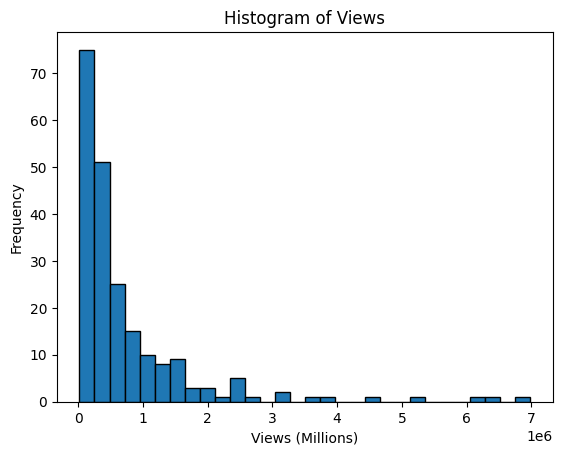

In [6]:
# Create histogram of 'Views'
plt.hist(data['Views'], bins=30, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Views')
plt.xlabel('Views (Millions)')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Calculate skewness
print("Skewness:", skew(data['Views']))

Skewness: 3.28728091234463


#### Key things to note:
* The range of **episode views** are from 18,223 to 6,984,529 views. With an average of 747,133 views per episode. The skewness value of 3.287 indicates that the distribution of the data is right-skewed, i.e. the majority of the data points are concentrated on the left side of the distribution. 
* The range of **title word count** are from 7 to 20. With an average of 13 words per episode title


## Preprocess the episode titles for the TF-IDF calculation

In [8]:
# Create new `pandas` methods which uses `tqdm` progress 
tqdm.pandas()

def preprocess_text(text):
    '''Prepare the title text for TF-IDF vectorizer'''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation)).replace('“', '').replace('”', '')

    # load spacy model
    nlp = spacy.load("en_core_web_sm")

    # Remove people's names
    doc = nlp(text)
    for name in [ent for ent in doc.ents]:
        if name.label_ == "PERSON":
            text = text.replace(str(name), '')

    # Remove less common names which aren't removed by the spacy model
    for remove_name in [' gawdat ', ' mo ', ' sinek ']:
        text = text.replace(remove_name, '')

    # Remove episode number using regex
    text = re.sub(r'e\d+', '', text)

    return text

# Apply preprocessing function to the 'Title' column
data['Preprocessed_titles'] = data['Title'].progress_apply(preprocess_text)

# Put the titles in a list
corpus = data['Preprocessed_titles'].tolist()

# Display the dataframe
data.head()

100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [01:25<00:00,  2.51it/s]


,Title,URL,Views,title_char_length,title_word_count,Preprocessed_titles
0,"CMO Of Netflix: ""Work Life Balance"" Is BAD Adv...",https://www.youtube.com/watch?v=cuVTVOdkmek,136578,79,16,cmo of netflix work life balance is bad advice...
1,WARNING: ChatGPT Could Be The Start Of The End...,https://www.youtube.com/watch?v=GmlrEgLGozw,519547,58,11,warning chatgpt could be the start of the end
2,"The Man Thats Ageing Backwards: “I Was 45, I’m...",https://www.youtube.com/watch?v=1yfoonW1InE,747145,71,14,the man thats ageing backwards i was 45 i’m no...
3,"will.i.am Opens Up: Depression, Creativity & A...",https://www.youtube.com/watch?v=1m-2QhqdlfI,447756,50,7,opens up depression creativity adhd
4,Shocking TRUE Story: “I Lost Both Of My Legs B...,https://www.youtube.com/watch?v=NB4jZCxRkTw,517779,98,18,shocking true story i lost both of my legs bec...


## Calculate TF-IDF of the keywords

TF-IDF (Term Frequency - Inverse Document Frequency) is a method to measure the importance of words in a document collection. It combines how often a word appears in a document (TF) with how unique it is across all documents (IDF) to highlight words that are both frequent in a document and distinctive to that document collection. In this case, we will be calculating how frequent the word appears in an episode title and how unique it is across all titles.

$TF(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$

$IDF(t, D) = \log\left(\frac{\text{Total number of documents in } D}{\text{Number of documents containing term } t + 1}\right)$


$TFIDF(t, d, D) = TF(t, d) \times IDF(t, D)$
​


In [9]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the titles using the TF-IDF vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Convert the TF-IDF matrix to a DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the TF-IDF matrix DataFrame
tfidf_df.head()

,10,100,1000,11,110,12,120lbs,127lb,14,15,...,wrongfully,yates,year,years,yeo,young,youngest,youtube,youve,yung
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
print(f"Count of unique words: {len(tfidf_vectorizer.get_feature_names_out())}")

Count of unique words: 807


In [11]:
# Calculate the average TF-IDF score for each word across all titles
average_tfidf_scores = tfidf_df.mean()

# Sort the words by average TF-IDF score in descending order
sorted_words = average_tfidf_scores.sort_values(ascending=False)

# Display the top N words with the highest average TF-IDF scores
top_n = 20 
top_words = sorted_words.head(top_n)

print("Top TF-IDF scoring Keywords:")
for word, score in top_words.items():
    print(f"{word}: {score:.4f}")

Top TF-IDF scoring Keywords:
life: 0.0286
founder: 0.0217
world: 0.0196
opens: 0.0190
story: 0.0189
billion: 0.0189
business: 0.0187
expert: 0.0163
man: 0.0153
million: 0.0148
built: 0.0148
secret: 0.0147
mind: 0.0129
anxiety: 0.0125
success: 0.0120
dark: 0.0116
happiness: 0.0112
untold: 0.0108
build: 0.0107
no1: 0.0106


'life', 'founder' and 'world' are the top TF-IDF scoring keywords, meaning they are both frequent in titles and distinctive to the title collection. This list doesn't really give us any insightful data to act upon just yet, so next we will find the correlation between keyword TF-IDF and view count 

First, let's visualise the distribution of a word TF-IDF score

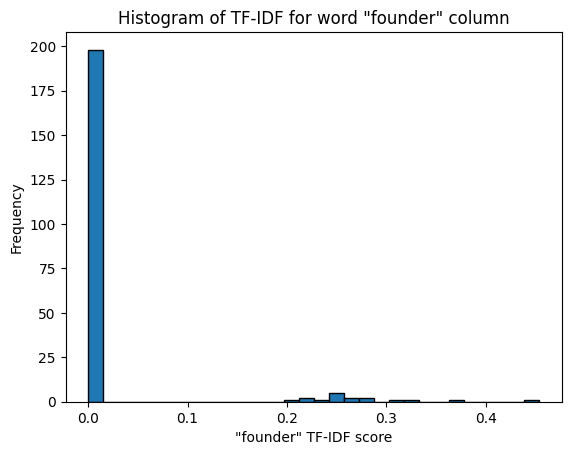

In [12]:
# Create histogram of "founder" TF-IDF column
plt.hist(tfidf_df['founder'], bins=30, edgecolor='black') 
plt.title('Histogram of TF-IDF for word "founder" column')
plt.xlabel('"founder" TF-IDF score')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Calculate skewness
print("Skewness:", skew(tfidf_df['founder']))

Skewness: 3.442225365575323


You will of course notice that majority of TF-IDF score values are zero, since the word doesn't appear in all titles.

## Find the correlation between Keyword TF-IDF and view count

Both the TF-IDF score and view count are nonnegative continuous variables that have a right skewed distribution, traditional correlation metrics like Pearson's correlation coefficient might not provide accurate insights due to their sensitivity to outliers and assumption of a normal distribution. In such case, we'll use Spearman's rank correlation coefficient which is a non-parametric measure of association between two variables, which means it doesn't assume any specific distribution of the data. It is less sensitive to outliers and is suitable for monotonic relationships between two variables.

In [14]:
# Calculate Spearman's rank correlation coefficient and p-value between each keyword and view counts
correlation_results = {}

for keyword in tfidf_df.columns:
    keyword_column = tfidf_df[keyword]
    correlation_coefficient, p_value = spearmanr(keyword_column, data['Views'])
    correlation_results[keyword] = (correlation_coefficient, p_value)

# Sort the words by correlation in descending order
sorted_words = sorted(correlation_results.items(), key=lambda x: x[1][0], reverse=True)

# Display the sorted words and their correlation
print("Top 20 Correlated Keywords with View Count:")
for i, val in enumerate(sorted_words):
    print(f"{val[0]}: Correlation Coefficient: {val[1][0]:.4f} | P-value: {val[1][1]} |  statistically significant: {val[1][1] < 0.05}")
    if i == 19:
        break

Top 20 Correlated Keywords with View Count:
man: Correlation Coefficient: 0.2005 | P-value: 0.0031515902849740024 |  statistically significant: True
weight: Correlation Coefficient: 0.1640 | P-value: 0.016083592143038075 |  statistically significant: True
loss: Correlation Coefficient: 0.1634 | P-value: 0.016479921925968723 |  statistically significant: True
calories: Correlation Coefficient: 0.1592 | P-value: 0.01947757603802582 |  statistically significant: True
sugar: Correlation Coefficient: 0.1545 | P-value: 0.02342206518401722 |  statistically significant: True
doctor: Correlation Coefficient: 0.1540 | P-value: 0.023910856556735454 |  statistically significant: True
live: Correlation Coefficient: 0.1532 | P-value: 0.024659225332160025 |  statistically significant: True
speaks: Correlation Coefficient: 0.1498 | P-value: 0.028075091842916986 |  statistically significant: True
love: Correlation Coefficient: 0.1486 | P-value: 0.02935317399335764 |  statistically significant: True
exp

## Data visualisation

There are some title keywords correlated to episode view count, some positively correlated and some negative. Let's visualise this in horizontal bar charts for easier consumption.

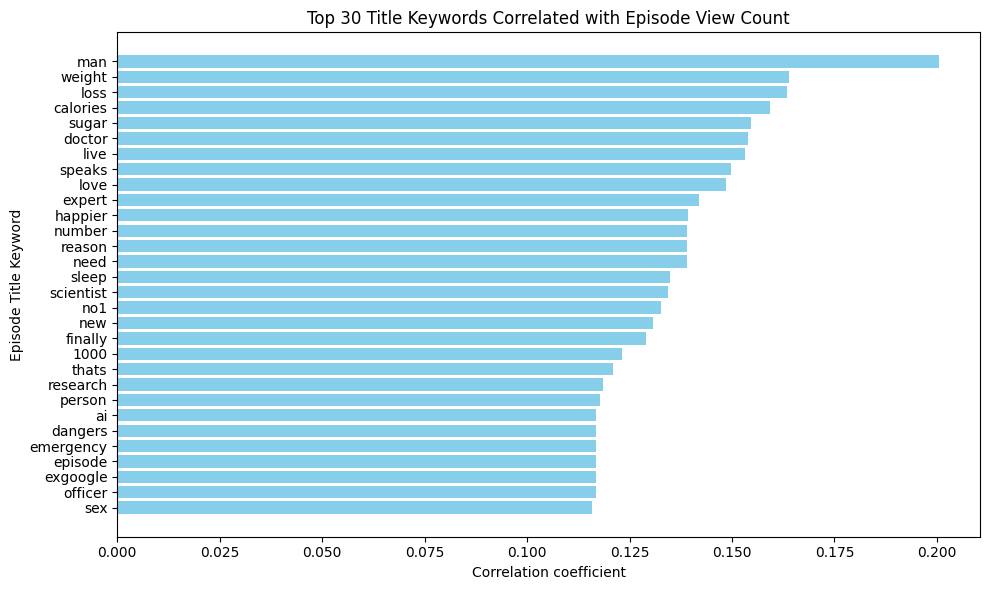

In [15]:
# Extract the top N words and their correlation coefficient for visualisation
top_n = 30 
top_words = [word for word, _ in sorted_words[:top_n]]
weighted_scores = [score[0] for _, score in sorted_words[:top_n]]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, weighted_scores, color='skyblue')
plt.xlabel('Correlation coefficient')
plt.ylabel('Episode Title Keyword')
plt.title(f'Top {top_n} Title Keywords Correlated with Episode View Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.tight_layout()

# Show the bar chart
plt.show()


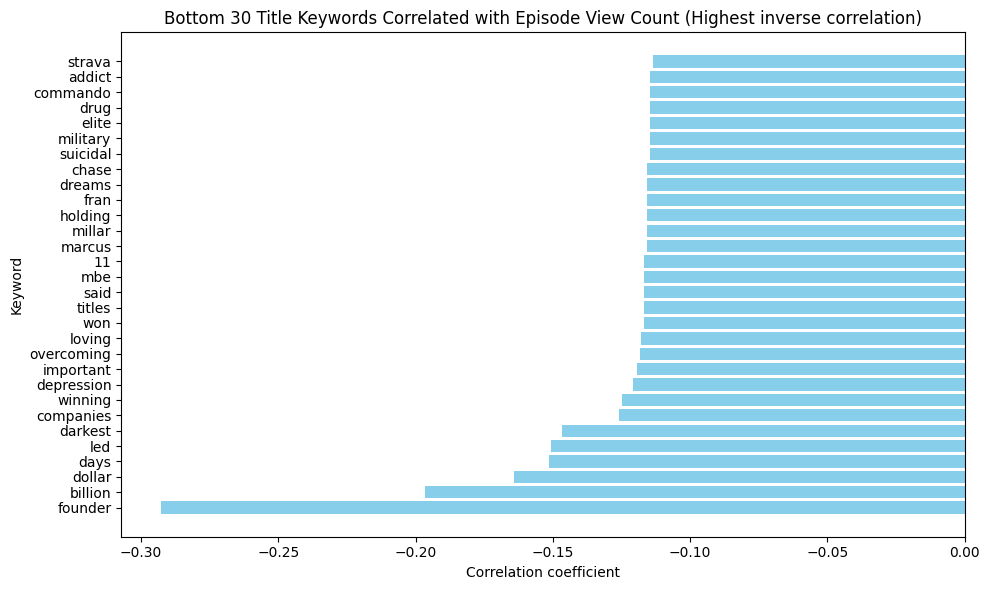

In [16]:
# Extract the bottom N words and their weighted scores for visualization
bottom_n = 30  
bottom_words = [word for word, _ in sorted_words[-bottom_n:]]
weighted_scores = [score[0] for _, score in sorted_words[-bottom_n:]]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(bottom_words, weighted_scores, color='skyblue')
plt.xlabel('Correlation coefficient')
plt.ylabel('Keyword')
plt.title(f'Bottom {bottom_n} Title Keywords Correlated with Episode View Count (Highest inverse correlation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.tight_layout()

# Show the bar chart
plt.show()

## Let's remove keywords where the correlation to view count is statistically insignificant.

We will use the commonly used significance level of 0.05 to indicate if the observed correlation coefficient is statistically significant. In other words, it is highly unlikely that such a correlation coefficient could have occurred due to random chance alone. 

In [17]:
# Create a DataFrame, calculate if p < 0.05 and then filter out statistically insignificant keywords
word_corr_df = pd.DataFrame([[keyword, score_tup[0], score_tup[1]] for keyword, score_tup in sorted_words], columns=['word', 'coefficient', 'p_value'])
word_corr_df['statistically_significant'] = word_corr_df['p_value'].apply(lambda x: x < 0.05)
word_corr_df = word_corr_df[word_corr_df['statistically_significant'] == True]
word_corr_df

,word,coefficient,p_value,statistically_significant
0,man,0.200483,0.003152,True
1,weight,0.164000,0.016084,True
2,loss,0.163402,0.016480,True
3,calories,0.159242,0.019478,True
4,sugar,0.154544,0.023422,True
5,doctor,0.154010,0.023911,True
6,live,0.153211,0.024659,True
7,speaks,0.149809,0.028075,True
8,love,0.148627,0.029353,True
9,expert,0.141925,0.037577,True


In [18]:
len(word_corr_df)

22

In this case, we are left with only 22 keywords that are considered statistically significant in correlation to views. The majority of words have only a small sample size across the entire dataset and thus there is possibly not enough data points to detect significant effects. 

All the correlation coefficients are between 0.3 and -0.3, meaning the strongest correlations are still considered weak. There are of course many variables that will affect the view count of episodes so to find some weak correlations here is still somewhat interesting and potentially useful.

Below we'll analyse the remaining keywords in more detail.

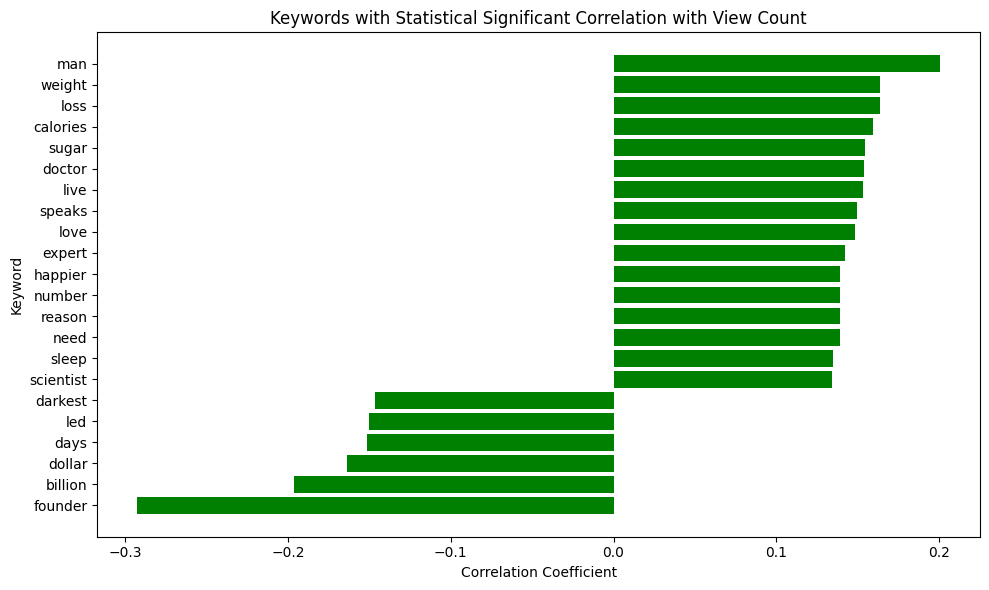

In [19]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(word_corr_df.word, word_corr_df.coefficient, color='green')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Keyword')
plt.title(f'Keywords with Statistical Significant Correlation with View Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.tight_layout()

# Show the bar chart
plt.show()


### There are some interesting findings here as well as some expected results
#### Positive Correlations:
* "man" was the title word that had the highest positive correlation with episode view count, suggesting that the audience is more inclined to watch an episode if the guest speaker is male, possibly due to a larger male audience (just a hypothesis without access to the data to validate this).
* Lots of words within the "Health and Wellbeing" category ("weight", "loss", "calories", "sugar", "sleep") that have a positive correlation to views, suggesting the audience is more likely to watch Health and Wellbeing topics than anything else.
* The nouns "doctor", "expert" and "scientist" suggesting viewers prefer to watch episodes with guests that are considered to be very knowledgeable about or skilful in a particular area. Perhaps this is expected, but it is valuable to know that these words should be included in the title if applicable.

#### Negative Correlations:
* Interestingly, "founder" has the most negative correlation to view count at -0.29. Suggesting that the viewers are not that interested in conversations with guest founders and are less likely to watch an episode when this word is mentioned.
* Similarly, "billion" and "dollar" are negatively correlated to view count, indicating the audience of DOAC are suprisingly not as interested in watching episodes about making money or businesses as they are about losing weight and improving health.


#### It will help us to understand and validate this difference between the most positively and negatively correlated words "man" and "founder" in terms of view count if we visualise them together in a scatter plot below.

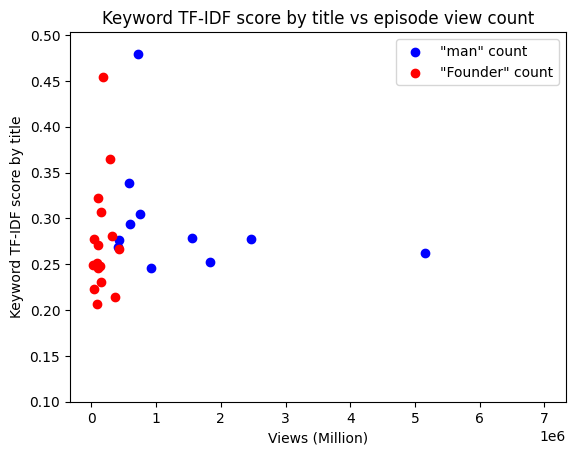

In [20]:
# Create a scatter plot
x = data['Views']
y1 = tfidf_df['man']
y2 = tfidf_df['founder']

plt.scatter(x, y1, color='blue', label='"man" count')
plt.scatter(x, y2, color='red', label='"Founder" count')

# Set the minimum value of the y-axis to 0.01 to remove episodes where the word count was 0
plt.ylim(0.1, None)

# Add labels, title and legend
plt.xlabel('Views (Million)')
plt.ylabel('Keyword TF-IDF score by title')
plt.title('Keyword TF-IDF score by title vs episode view count')
plt.legend()

# Display the plot
plt.show()

Each data point is a single title. By removing the titles with zero-count occurences (TF-IDF score of 0) we can quite easily see here that there is indeed a significant difference between the red and blue clusters. When the word "man" is used in the title the number of episode views is increased relative to when the word "founder" is present in the title, validating our Spearman's rank correlation coefficient results above.

## Conclusion



This notebook has aimed to analyse only the keywords in the title of the podcast and indirectly the topic of the episode against the view count it received. This analysis has been somewhat insightful in that we have identified a number of keywords that are weakly correlated with view count and thus would benefit the podcast host by helping him understand which title words and topics have been most impactful in his podcast. This information can guide future title creation or choice of episode topics to optimize engagement and viewership. A key insight I personally found surprising was that the audience favours health and wellbeing topics against business and money making topics, which is the opposite of my initial assumption considering the podcast is titled "Dairy of a CEO" and hosted by Steven Bartlett who is known for his success as an entrepreneur and investor. It's worth highlighting again that all correlations between words and views were weak at most, suggesting that there are many more factors that contribute to the view count of an episode other than title words (and thus episode topic).

## Appendix

Below is a slight variation to the correlation analysis by using a binary indicator of 1 if a word appears in a title instead of using TD-IDF to calculate the Spearman's rank correlation coefficient. This is to determine if this variation would give a similar result.

In [21]:
df = data.copy()

# List of words to analyze
words_to_analyze = list(tfidf_vectorizer.get_feature_names_out())

# Tokenize titles
df['Tokenized_titles'] = df['Preprocessed_titles'].apply(word_tokenize)

# Create indicator columns for each word
for word in words_to_analyze:
    df[word + '_indicator'] = df['Tokenized_titles'].apply(lambda tokens: int(word in tokens))
    
# Calculate Spearman's rank correlation coefficient and p-value between each keyword and view counts
word_list = []
correlation_coefficient_list = []
p_value_list = []

# Calculate correlation for each word's indicator column
for word in words_to_analyze:
    word_list.append(word)
    correlation_coefficient, p_value = spearmanr(df[word + '_indicator'], df['Views'])
    correlation_coefficient_list.append(correlation_coefficient)
    p_value_list.append(p_value)
    
correlation_results = {
    'word': word_list,
    'correlation_coefficient': correlation_coefficient_list,
    'p_value': p_value_list
}
    
spear_coeff_df = pd.DataFrame(correlation_results)
spear_coeff_df.sort_values('correlation_coefficient', ascending=False).dropna()

C:\GIT\DOAC-podcast-NLP\env\lib\site-packages\ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()
C:\GIT\DOAC-podcast-NLP\env\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,word,correlation_coefficient,p_value
444,man,0.201697,0.002970
778,weight,0.164164,0.015977
432,loss,0.164164,0.015977
119,calories,0.159251,0.019471
214,doctor,0.155154,0.022874
...,...,...,...
401,led,-0.150299,0.027560
188,days,-0.151418,0.026412
216,dollar,-0.163591,0.016354
88,billion,-0.199462,0.003312


The results are indeed the same as using the TD-IDF score.